In [1]:
import numpy as np 
import pandas as pd 
import pickle

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
sys.path.append('..')

from utils.viz import viz 
from utils.model import *  
from utils.fig_fn import *
viz.get_style()

In [6]:
data_set = 'exp2'
block_types = ['cons', 'cont', 'conf']
models = ['ecPG_fea', 'caPG_fea', 'rmPG_fea', 'LC', 'MA', 'ACL', 'l1PG_fea', 'l2PG_fea', 'rndPG_fea', 'dcPG_fea'] 
method = 'mle'
dpi = 300

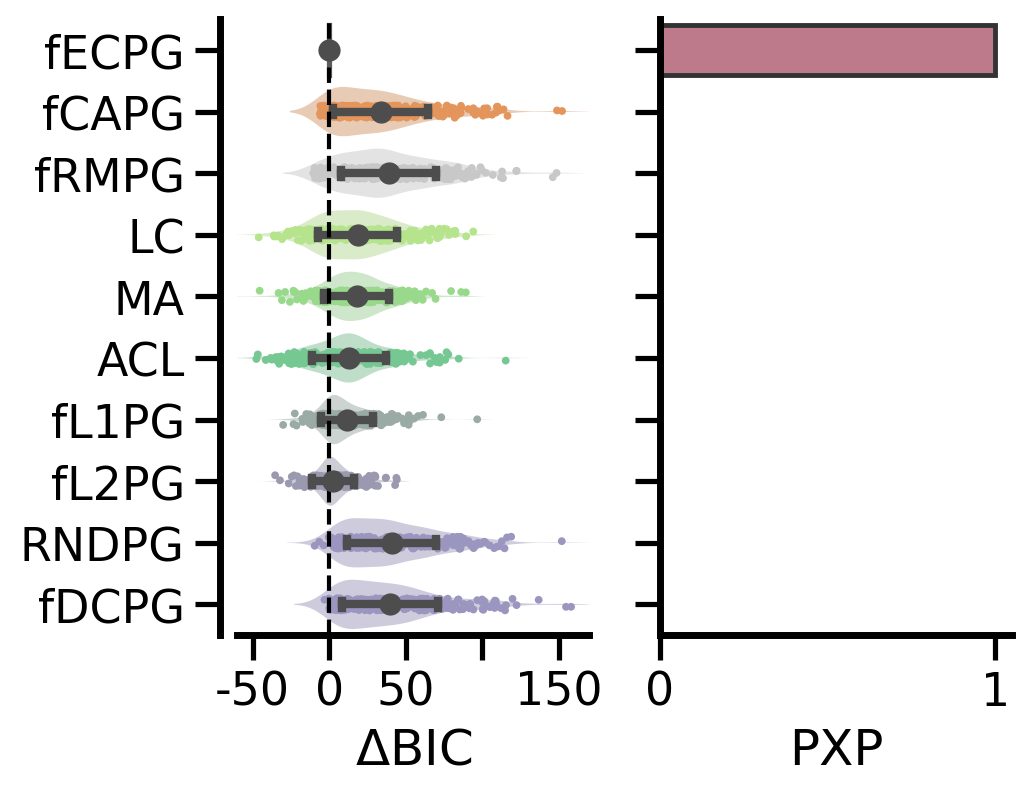

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(5, 4), sharey=True)
model_compare_violin(axs, data_set, models)
plt.savefig('../figures/exp2/Fig7B_model_compare.pdf', dpi=dpi)

### Fig. 6A model comparison

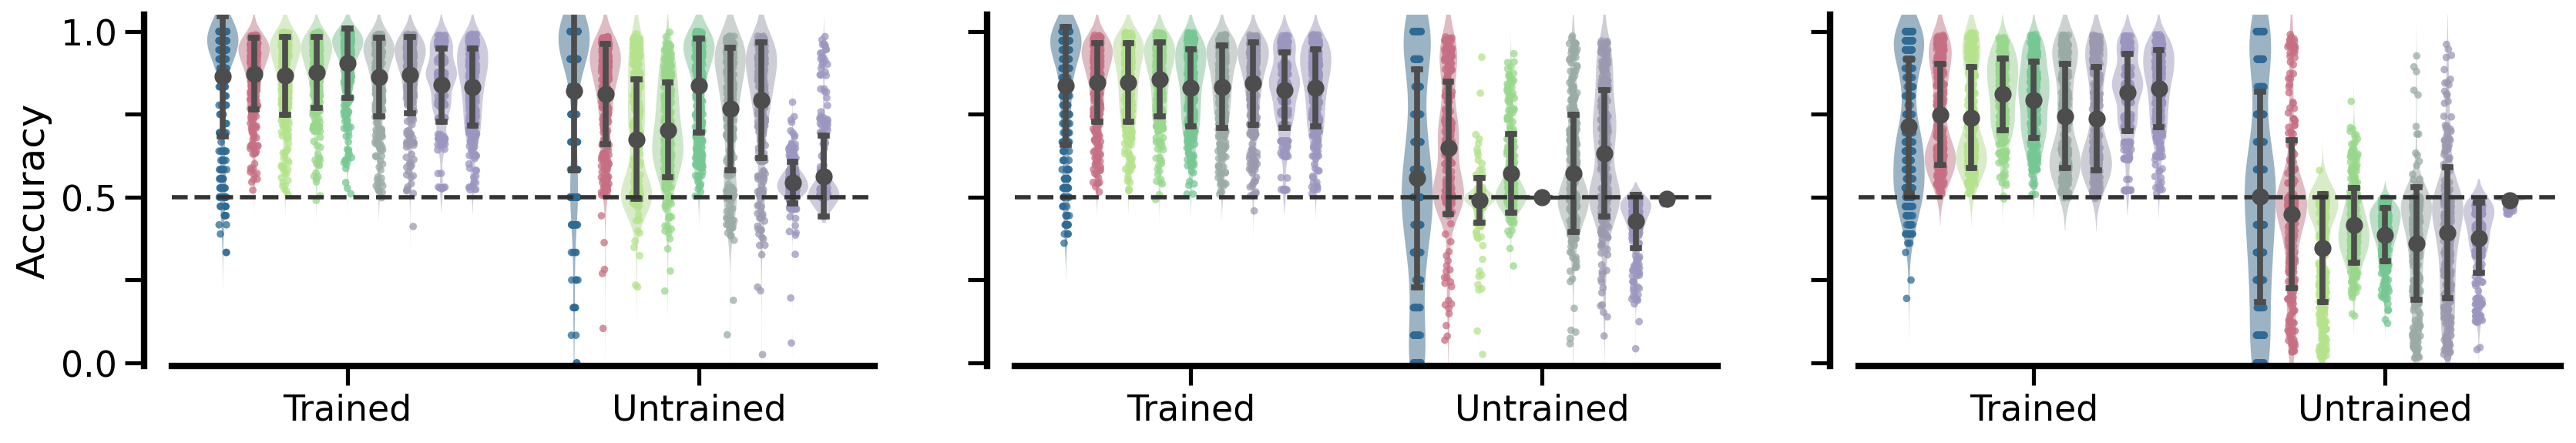

In [8]:
models = ['ecPG_fea', 'LC', 'MA', 'ACL', 'l1PG_fea', 'l2PG_fea', 'rndPG_fea', 'dcPG_fea'] 
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
generalize_exp2(axs, 'exp2', ['human']+models, method='map')
for ax in axs: ax.set_box_aspect(.5)
plt.savefig('../figures/exp2/Fig7C_generalization.pdf', dpi=dpi)

## Correlation with probe 

In [9]:
def get_untrained_corr_matrix(data_set, models, method='mle', goodPoor=None):
    p_tables = {} 
    conds = ['cons', 'cont', 'conf']
    for i, m in enumerate(['human']+models):
        if m == 'human':
            fname = f'{pth}/../data/{data_set}-human.csv'
        else:
            fname = f'{pth}/../simulations/{data_set}/{m}/sim-{method}.csv'
        data = pd.read_csv(fname, index_col=0)
        data['group'] = data['group'].map({
                    'control': 'trained', 
                    'trained': 'trained',
                    'untrained': 'untrained'
            })
        sdata = data.query('stage=="test"&group=="untrained"').copy()
        if goodPoor is not None: sdata = sdata.query(f'goodPoor=="good"').copy() 
        if m!='human': sdata['r'] = sdata['acc']
        sel_data = sdata.groupby(by=['sub_id', 'block_type']
                                )['r'].mean().reset_index()
        p_tables[m] = {c: sel_data.query(f'block_type=="{c}"')['r'].values for c in conds}
    corr_data = {'corr': [], 'model':[], 'cond':[]}
    for i, cond in enumerate(conds):
        y = p_tables['human'][cond].reshape([-1])
        for m in models:
            x = p_tables[m][cond].reshape([-1])
            corr_lm = pg.corr(x, y, method='spearman')
            #print(corr_lm)
            r = corr_lm["r"][0]
            corr_data['corr'].append(r)
            corr_data['model'].append(m)
            corr_data['cond'].append(cond)
    corr_data = pd.DataFrame.from_dict(corr_data).pivot_table(
                    values='corr', index='cond', columns='model'
                    ).loc[['cons', 'cont', 'conf'], models]
    return corr_data

In [11]:
models = ['ecPG_fea', 'LC', 'MA', 'ACL', 'l1PG_fea', 'l2PG_fea', 'rndPG_fea', 'dcPG_fea'] 
corr_data = get_prob_corr_matrix('exp2', models=models, method='map')


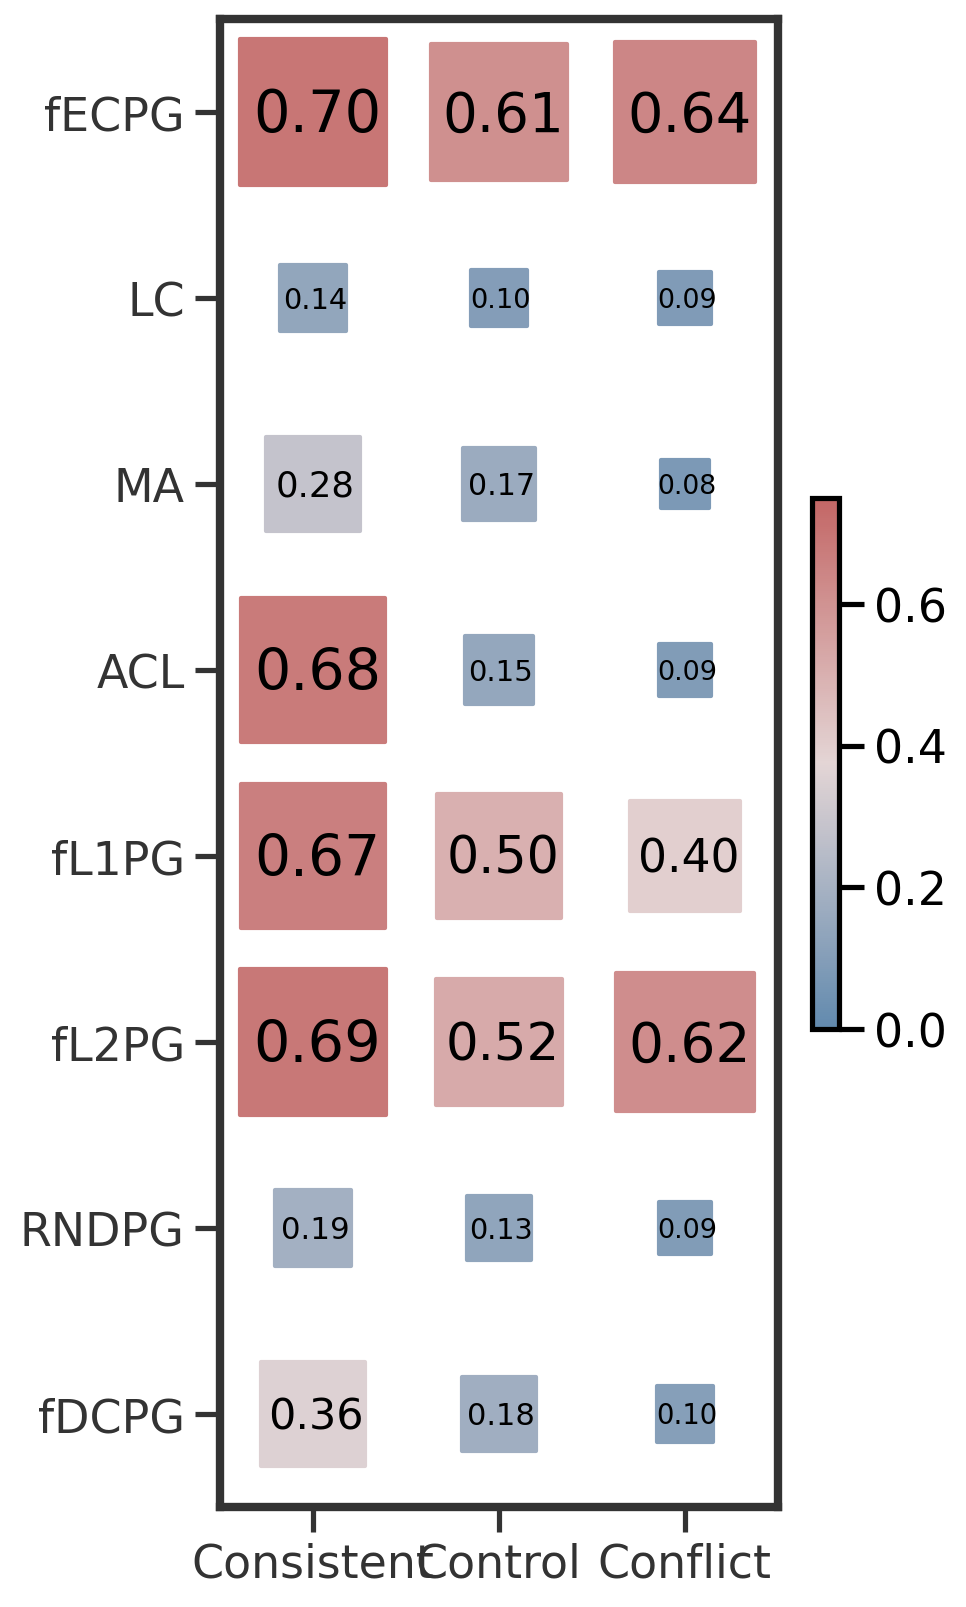

In [12]:
fig, ax = plt.subplots(figsize=(4.5, 1.8+1.5*len(models)))
show_prob_corr_matrix(ax, corr_data.transpose(), models=models, font_scale=43, marker_scale=4000)
plt.savefig(f'../figures/{data_set}/Fig6E_probe_corr_mat.pdf', dpi=dpi)